In [1]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime
from os import listdir, walk
from os.path import isfile, join
import time

"Data Viz"
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import Grid

%matplotlib inline

"Data Prep and Model Evaluation"
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
from keras.utils import to_categorical
from sklearn.metrics import adjusted_rand_score
import random
from scipy.signal import savgol_filter

"Tensor Decomposition"
from sklearn.decomposition import FactorAnalysis, PCA

import tensorly as tl
from tensorly import unfold as tl_unfold
from tensorly.decomposition import parafac


"Algos"
from kshape.core import kshape, zscore
import tslearn
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import KShape, TimeSeriesScalerMeanVariance,silhouette_score
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesResampler
import hdbscan

"TensorFlow and Keras"
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import LeakyReLU, Reshape, UpSampling2D, Conv2DTranspose
from keras.layers import BatchNormalization, Input, Lambda
from keras.layers import Embedding, Flatten, dot
from keras import regularizers
from keras.losses import mse, binary_crossentropy
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Adam, RMSprop
from tensorflow.examples.tutorials.mnist import input_data

Using TensorFlow backend.


In [2]:
seed = 2019
current_path = os.getcwd()
file_semana_1 = '\\datasets\\Dataset_Ananda\\data\\down_series_giga_10min_2018-08-20_2018-08-26.csv'
file_semana_2 = '\\datasets\\Dataset_Ananda\\data\\down_series_giga_10min_2018-08-27_2018-09-02.csv'
file_semana_3 = '\\datasets\\Dataset_Ananda\\data\\down_series_giga_10min_2018-09-03_2018-09-09.csv'
file_semana_4 = '\\datasets\\Dataset_Ananda\\data\\down_series_giga_10min_2018-09-10_2018-09-16.csv'

files = [file_semana_1,file_semana_2,file_semana_3,file_semana_3]
data = pd.DataFrame();
for i in files:
    data_ = pd.read_csv(current_path + i)
    data_ = data_.drop('Unnamed: 0',axis=1)
    data = pd.concat([data,data_])


columns_interpolate = data.drop(['user','day'],axis=1).columns
data.loc[:,columns_interpolate]=data.loc[:,columns_interpolate].interpolate(axis=0,limit_direction='both')

In [3]:
X_data = to_time_series_dataset(data.drop(['user','day'],axis=1).loc[:,'00:00':].values)
portion = 42336
X_data_portion = X_data[np.random.choice(X_data.shape[0], portion, replace=False), :]
for i in np.arange(0,X_data_portion.shape[0]):
    x = savgol_filter(X_data_portion[i,:].ravel(), 101, 3).reshape(1440,1)
    x = np.where(x<0, 0, x) 
    X_data_portion[i,:] = x 
X_data_portion= TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(X_data_portion)    
X_data_portion_re = TimeSeriesResampler(sz=700).fit_transform(X_data_portion)  # Make time series shorter

X_train = X_data_portion_re
seed = np.random.randint(1000)
sz = X_train.shape[1]
n_clusters = 6

In [4]:
dba_km = TimeSeriesKMeans(n_clusters=n_clusters, n_init=2, metric="dtw", verbose=True, max_iter_barycenter=10, random_state=seed)
y_pred = dba_km.fit_predict(X_train)

Init 1
28.473 --> 19.683 --> 18.764 --> 18.136 --> 17.957 --> 17.860 --> 17.777 --> 17.698 --> 17.656 --> 17.618 --> 17.595 --> 17.576 --> 17.564 --> 17.557 --> 17.555 --> 17.554 --> 17.552 --> 17.551 --> 17.545 --> 17.543 --> 17.539 --> 17.526 --> 17.495 --> 17.462 --> 17.454 --> 17.432 --> 17.415 --> 17.413 --> 17.408 --> 17.404 --> 17.403 --> 17.403 --> 17.403 --> 
Init 2
28.881 --> 18.438 --> 17.350 --> 17.064 --> 16.970 --> 16.942 --> 16.937 --> 16.931 --> 16.930 --> 16.928 --> 16.928 --> 


In [4]:
euc_km = TimeSeriesKMeans(n_clusters=n_clusters, n_init=5, metric="euclidean", verbose=True, max_iter_barycenter=10, random_state=seed)
y_pred = euc_km.fit_predict(X_train)

Init 1
775.851 --> 494.359 --> 484.537 --> 480.958 --> 478.619 --> 477.359 --> 476.671 --> 476.266 --> 475.962 --> 475.742 --> 475.554 --> 475.408 --> 475.290 --> 475.194 --> 475.104 --> 475.027 --> 474.935 --> 474.860 --> 474.779 --> 474.677 --> 474.567 --> 474.466 --> 474.376 --> 474.284 --> 474.181 --> 474.083 --> 473.988 --> 473.895 --> 473.805 --> 473.733 --> 473.671 --> 473.614 --> 473.562 --> 473.518 --> 473.482 --> 473.450 --> 473.426 --> 473.403 --> 473.383 --> 473.364 --> 473.348 --> 473.333 --> 473.319 --> 473.304 --> 473.297 --> 473.293 --> 473.289 --> 473.287 --> 473.284 --> 473.280 --> 
Init 2
769.367 --> 506.444 --> 495.391 --> 491.784 --> 489.592 --> 487.766 --> 486.089 --> 483.693 --> 480.394 --> 478.858 --> 478.448 --> 478.324 --> 478.266 --> 478.238 --> 478.220 --> 478.208 --> 478.201 --> 478.195 --> 478.188 --> 478.179 --> 478.171 --> 478.166 --> 478.159 --> 478.154 --> 478.148 --> 478.144 --> 478.143 --> 478.141 --> 478.140 --> 478.138 --> 478.136 --> 478.135 --> 4

In [9]:
sdtw_km = TimeSeriesKMeans(n_clusters=n_clusters,n_init=2, metric="softdtw", metric_params={"gamma_sdtw": .01},
                           verbose=True, random_state=seed)
y_pred = sdtw_km.fit_predict(X_train)

Init 1
3167.118 --> 668.629 --> 556.500 --> 530.328 --> 520.779 --> 514.217 --> 512.410 --> 511.390 --> 510.252 --> 509.414 --> 508.922 --> 507.197 --> 506.953 --> 506.983 --> 506.874 --> 506.907 --> 506.798 --> 506.669 --> 506.548 --> 506.482 --> 506.305 --> 506.311 --> 506.182 --> 506.181 --> 506.072 --> 506.007 --> 505.948 --> 505.927 --> 505.843 --> 505.839 --> 505.765 --> 505.763 --> 505.708 --> 505.708 --> 505.658 --> 505.649 --> 505.645 --> 505.639 --> 505.548 --> 505.568 --> 505.507 --> 505.515 --> 505.462 --> 505.463 --> 505.408 --> 505.407 --> 505.362 --> 505.366 --> 505.327 --> 505.335 --> 
Init 2
2752.281 --> 1083.905 --> 978.085 --> 905.279 --> 868.371 --> 814.433 --> 642.568 --> 552.667 --> 528.007 --> 525.705 --> 521.969 --> 517.846 --> 516.907 --> 515.892 --> 515.112 --> 514.161 --> 512.464 --> 512.156 --> 510.977 --> 510.768 --> 510.591 --> 510.413 --> 509.641 --> 509.499 --> 509.254 --> 508.996 --> 508.692 --> 508.570 --> 508.084 --> 507.726 --> 507.470 --> 507.312 --

In [4]:
start_time = time.time()

ks = KShape(n_clusters=8, n_init=7, verbose=True, random_state=seed)
y_pred = ks.fit_predict(X_train)

elapsed_time = time.time() - start_time

Init 1
0.081 --> 0.075 --> 0.073 --> 0.072 --> 0.071 --> 0.070 --> 0.070 --> 0.069 --> 0.069 --> 0.069 --> 0.068 --> 0.068 --> 0.068 --> 0.068 --> 0.068 --> 0.068 --> 0.068 --> 0.068 --> 0.068 --> 0.068 --> 0.068 --> 0.068 --> 0.068 --> 0.068 --> 0.068 --> 0.068 --> 0.068 --> 0.068 --> 0.068 --> 0.068 --> 0.068 --> 
Init 2
0.075 --> 0.071 --> 0.069 --> 0.068 --> 0.067 --> 0.067 --> 0.066 --> 0.066 --> 0.066 --> 0.066 --> 0.066 --> 0.066 --> 
Init 3
0.076 --> 0.072 --> 0.071 --> 0.071 --> 0.070 --> 0.070 --> 0.069 --> 0.069 --> 0.068 --> 0.068 --> 0.067 --> 0.067 --> 0.067 --> 0.067 --> 0.067 --> 0.067 --> 
Init 4
0.078 --> 0.074 --> 0.071 --> 0.070 --> 0.069 --> 0.068 --> 0.067 --> 0.067 --> 0.067 --> 0.067 --> 0.067 --> 0.067 --> 0.067 --> 0.067 --> 0.067 --> 0.067 --> 0.067 --> 
Init 5
0.076 --> 0.073 --> 0.071 --> 0.070 --> 0.069 --> 0.068 --> 0.068 --> 0.068 --> 0.068 --> 0.067 --> 0.067 --> 0.067 --> 0.067 --> 0.067 --> 0.067 --> 0.067 --> 0.067 --> 0.067 --> 0.067 --> 
Init 6
0.0

In [23]:
start_time = time.time()

MAX_Clusters = 12
inertias = np.zeros(MAX_Clusters)
for n_clusters in range(1,MAX_Clusters+1):
    #ks = KShape(n_clusters=n_clusters, n_init=5, verbose=False, random_state=seed)
    #y_pred = ks.fit_predict(X_train)
    #inertias[n_clusters-1] = ks.inertia_
    
    euc_km = TimeSeriesKMeans(n_clusters=n_clusters, n_init=2, metric="dtw", verbose=True, max_iter_barycenter=10, random_state=seed)
    y_pred = euc_km.fit_predict(X_train)
    inertias[n_clusters-1] = euc_km.inertia_
    
elapsed_time = time.time() - start_time
print (elapsed_time)

Init 1
31.348 --> 22.683 --> 22.577 --> 22.577 --> 
Init 2
33.662 --> 22.259 --> 22.259 --> 22.259 --> 
Init 1
27.454 --> 21.567 --> 21.085 --> 20.936 --> 20.843 --> 20.764 --> 20.605 --> 20.519 --> 20.316 --> 20.129 --> 18.435 --> 17.960 --> 17.908 --> 17.887 --> 17.877 --> 17.866 --> 17.866 --> 
Init 2
27.030 --> 18.387 --> 18.195 --> 17.977 --> 17.838 --> 17.812 --> 17.750 --> 17.737 --> 17.736 --> 17.736 --> 
Init 1
23.566 --> 18.005 --> 17.665 --> 17.405 --> 17.264 --> 17.165 --> 17.111 --> 17.077 --> 17.055 --> 17.012 --> 16.987 --> 16.978 --> 16.973 --> 16.970 --> 16.942 --> 16.927 --> 16.927 --> 
Init 2
22.454 --> 17.208 --> 16.808 --> 16.562 --> 16.463 --> 16.419 --> 16.393 --> 16.391 --> 16.391 --> 
Init 1
21.971 --> 16.551 --> 16.193 --> 16.061 --> 16.026 --> 16.007 --> 16.001 --> 15.999 --> 15.996 --> 15.991 --> 15.984 --> 15.975 --> 15.945 --> 15.914 --> 15.796 --> 15.710 --> 15.644 --> 15.606 --> 15.581 --> 15.529 --> 15.011 --> 14.841 --> 14.789 --> 14.752 --> 14.658 -->

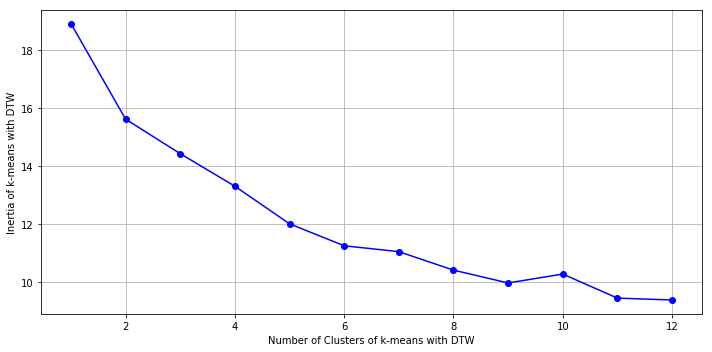

In [20]:
#portion = 300, samples = 50 , n_init = 2 , DTW , portion from all data, 2800 seconds
inertias_300_50 = inertias.copy()
plt.rcParams['figure.figsize'] = [10,5]
plt.figure()
plt.plot(range(1,MAX_Clusters+1),inertias,'bo-')
plt.xlabel('Number of Clusters of k-means with DTW')
plt.ylabel('Inertia of k-means with DTW')
plt.grid(True)
plt.tight_layout()
plt.show()

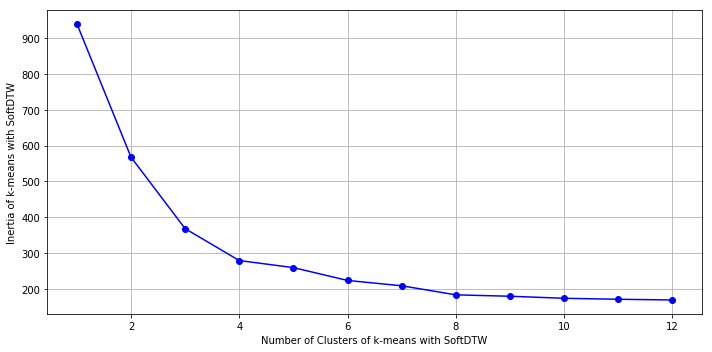

In [12]:
#portion = 300, samples = 50 , n_init = 2 , SoftDTW , portion from all data, 2983 seconds
inertias_300_50 = inertias.copy()
plt.rcParams['figure.figsize'] = [10,5]
plt.figure()
plt.plot(range(1,MAX_Clusters+1),inertias,'bo-')
plt.xlabel('Number of Clusters of k-means with SoftDTW')
plt.ylabel('Inertia of k-means with SoftDTW')
plt.grid(True)
plt.tight_layout()
plt.show()

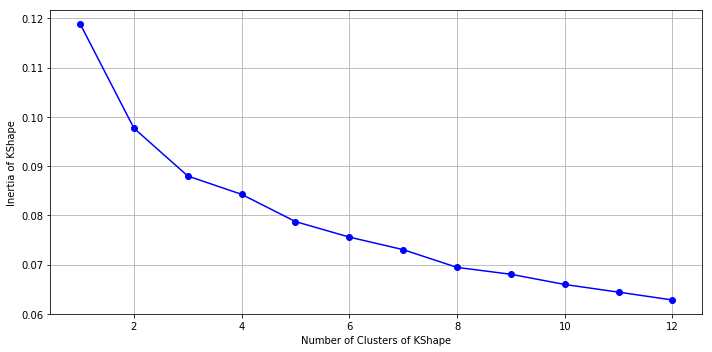

In [63]:
#portion = 4750, samples = 360 , n_init = 5 , KS , portion from all data
inertias_4750_360 = inertias.copy()
plt.rcParams['figure.figsize'] = [10,5]
plt.figure()
plt.plot(range(1,MAX_Clusters+1),inertias,'bo-')
plt.xlabel('Number of Clusters of KShape')
plt.ylabel('Inertia of KShape')
plt.grid(True)
plt.tight_layout()
plt.show()

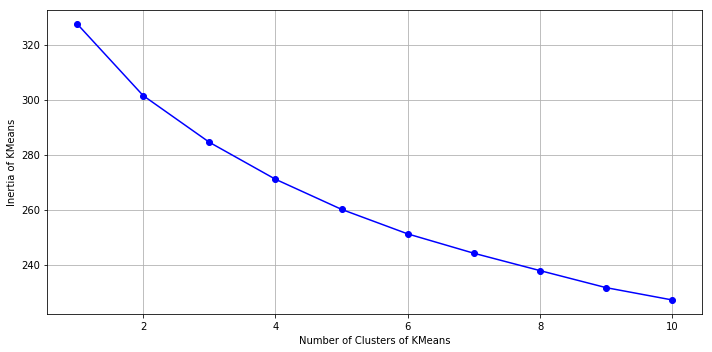

In [56]:
#portion = 4750, samples = 360 , n_init = 5 , euclidean , portion from all data
inertias_4750_360 = inertias.copy()
plt.rcParams['figure.figsize'] = [10,5]
plt.figure()
plt.plot(range(1,MAX_Clusters+1),inertias,'bo-')
plt.xlabel('Number of Clusters of KMeans')
plt.ylabel('Inertia of KMeans')
plt.grid(True)
plt.tight_layout()
plt.show()

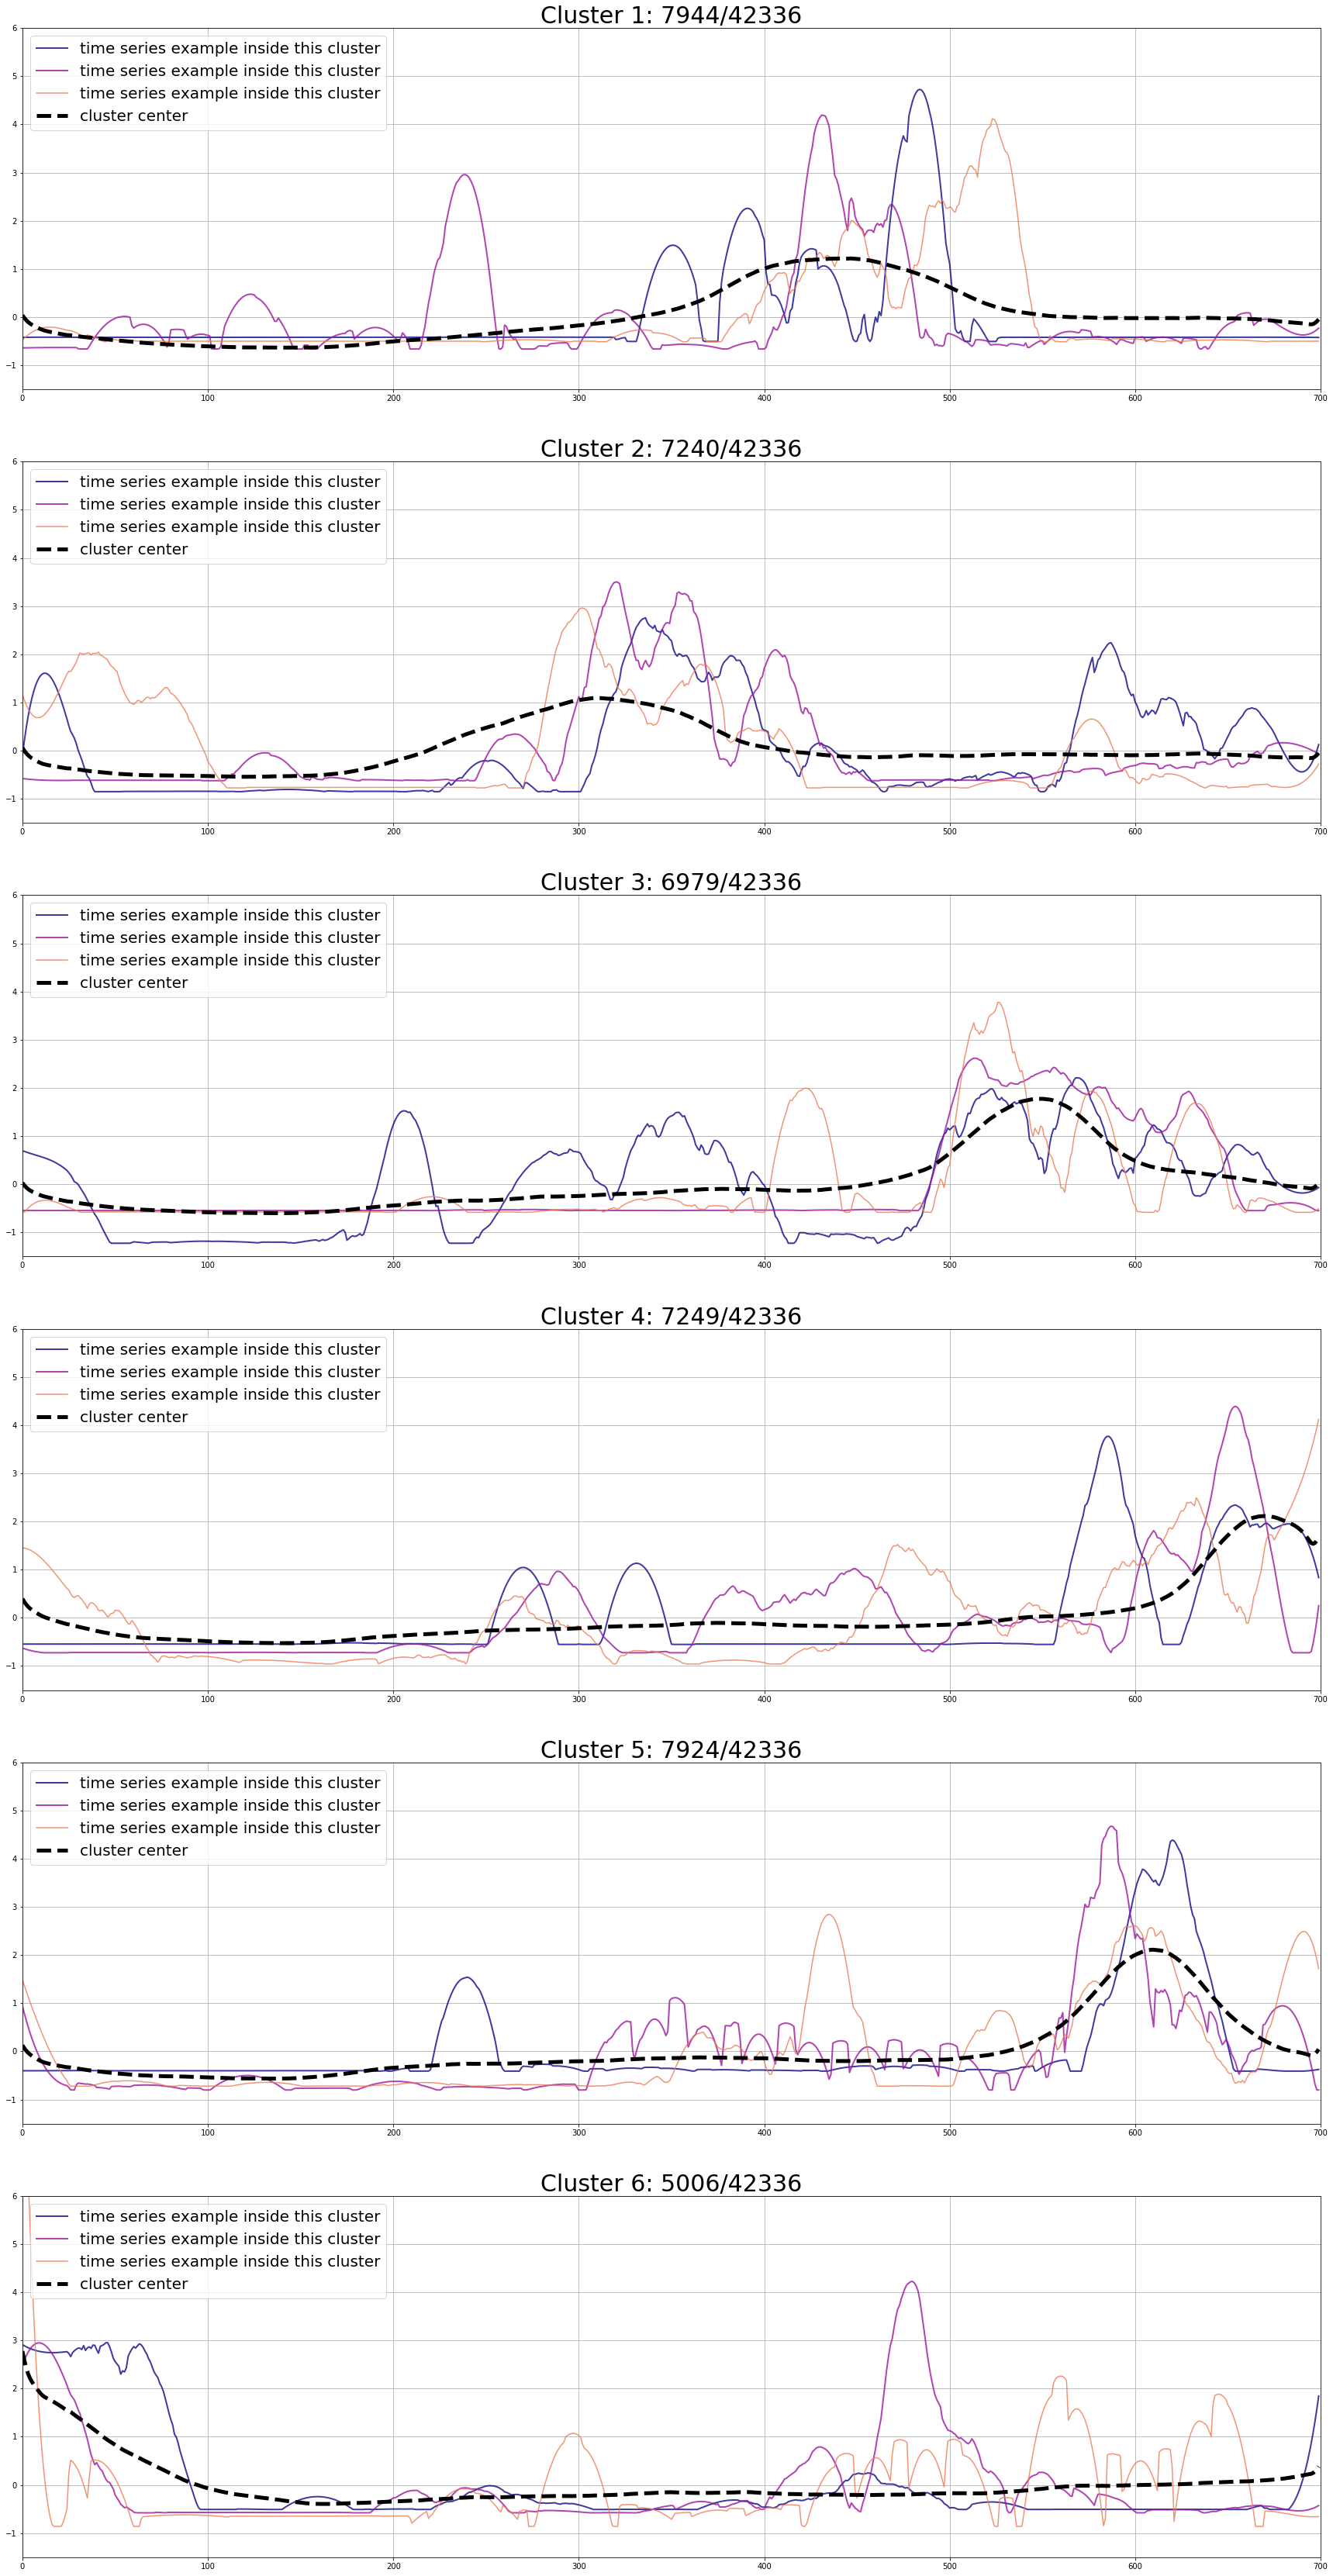

In [5]:
#plt.figure()

KC =euc_km
n_clusters = 6
plt.rcParams['figure.figsize'] = [30,60]
c = 3;

cmap = mpl.cm.plasma

for yi in range(n_clusters):    
    plt.subplot(n_clusters, 1, yi + 1)
    plt.grid(True)
    acc = np.zeros((1,len(X_train[0]))) 
    
    ball = X_train[y_pred == yi]
    ball = ball[np.random.choice(ball.shape[0], c, replace=False)]
    
    for xx in X_train[y_pred == yi]:
        acc = np.append(acc,[xx.ravel()],axis=0)
        
    for idx,xx in enumerate(ball):
        
        if (idx < (ball.shape[0] - 1)):
            plt.plot(xx.ravel(), alpha=.8,linewidth=2.0 ,label = 'time series example inside this cluster', color=cmap(idx / float(ball.shape[0])))
            
    plt.plot(xx.ravel(),label = 'time series example inside this cluster', alpha=.8 , color=cmap(idx / float(ball.shape[0])))
    
    #plt.plot(np.mean(acc,axis=0), "y-", label = 'mean of series inside cluster',linewidth=5.0)                   
    plt.plot(KC.cluster_centers_[yi].ravel(), "k-",linewidth=5.0 ,linestyle='--',label = 'cluster center')
    plt.legend(loc='upper left', fontsize=20)
    plt.xlim(0, sz)
    s = 'Cluster ' + str(yi+1) + ': ' + str(len(acc)) + '/' + str(X_train.shape[0]);
    plt.title(s,fontsize=30)
    #print('Quantity of time series in the', yi+1,'cluster:',len(acc))    

      
    plt.ylim(bottom=-1.5, top =6.0)
plt.show()